In [1]:
import os
import sys
import json
import pickle
import gzip
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
from biock.plot._plot import set_spines, get_figure_size

In [2]:
## generated by `evaluate_mlm_per_region.py`:
vert_bacc = [0.455, 0.493, 0.490, 0.641, 0.511, 0.636]
repeat_bacc = [0.631, 0.705, 0.693, 0.699, 0.624, 0.667]
nr_bacc = [0.439, 0.491, 0.440, 0.545, 0.451, 0.539]

In [3]:
# MLM-ACC: intron/exon $\approx$ 30%
print(vert_bacc[3] / np.mean(vert_bacc[:3]))
print(vert_bacc[-1] / vert_bacc[2])

1.3372739916550764
1.2979591836734694


In [4]:
protein_coding_stats = list()
for regions in ["UTR5", "CDS", "UTR3", "intron"]:
    fn = f"../data/genomic_function_region/genomic_function_region.protein_coding.{regions}.bed"
    df = pd.read_csv(fn, sep="\t", header=None)
    lengths = (df[2] - df[1]).to_numpy()
    total = np.sum(lengths)
    fn = f"../data/genomic_function_region/genomic_function_region.protein_coding.{regions}.in_repeat.bed"
    df = pd.read_csv(fn, sep="\t", header=None)
    lengths = (df[2] - df[1]).to_numpy()
    repeat = np.sum(lengths)
    print(regions, repeat/total)
    protein_coding_stats.append((regions, repeat/total))

lncRNA_stats = list()
for regions in ["exon", "intron"]:
    fn = f"../data/genomic_function_region/genomic_function_region.lncRNA.{regions}.bed"
    df = pd.read_csv(fn, sep="\t", header=None)
    lengths = (df[2] - df[1]).to_numpy()
    total = np.sum(lengths)
    fn = f"../data/genomic_function_region/genomic_function_region.lncRNA.{regions}.in_repeat.bed"
    df = pd.read_csv(fn, sep="\t", header=None)
    lengths = (df[2] - df[1]).to_numpy()
    repeat = np.sum(lengths)
    print(regions, repeat/total)
    lncRNA_stats.append((regions, repeat/total))

UTR5 0.16090193938055766
CDS 0.023379456022206722
UTR3 0.1835823370933863
intron 0.46058405468079067
exon 0.37060982097890793
intron 0.5126231687939264


/tmp/ipykernel_2135537/2447154200.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}%" for x in ax.get_yticks() * 100])


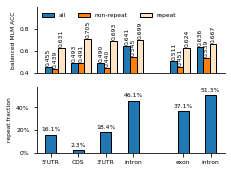

In [6]:
inds = np.asarray([0, 1, 2, 3, 4.8, 5.8])

fs = 6
# set xlabel/ylabel fontsize
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=get_figure_size(0.4, 0.6 * 0.5))


ax = axs[0]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=vert_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.4, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], vert_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.4, 0.6, 0.8])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax = axs[1]
set_spines(ax)
width = 0.4
ax.bar(x=inds, height=[x[1] for x in protein_coding_stats + lncRNA_stats], width=width, edgecolor="black", color="tab:blue")
# annotate the bars
for i, (regions, repeat) in enumerate(protein_coding_stats + lncRNA_stats):
    ax.text(x=inds[i], y=repeat + 0.02, s=f"{100 * repeat:.1f}%", ha="center", va="bottom", fontsize=fs)
ax.set_ylabel("repeat fraction")
ax.set_ylim(0, 0.58)
ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])
ax.set_yticklabels([f"{x:.0f}%" for x in ax.get_yticks() * 100])





# legend in 2 columns
# ax.legend(handles, labels, loc="upper left", frameon=False, fontsize=fs, ncol=2)
ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])
ax.set_yticks([0, 0.2, 0.4])
# ax.set_yl

plt.tight_layout()
plt.savefig("repeat_fraction.svg", bbox_inches="tight", transparent=False)
plt.savefig("repeat_fraction.jpg", dpi=600)